In [28]:
import os

project_path = r"C:\Users\user\anaconda3\envs\Chicken-disease-Classification-Project"

os.chdir(project_path)
print(f"Moved to: {os.getcwd()}")


Moved to: C:\Users\user\anaconda3\envs\Chicken-disease-Classification-Project


In [29]:
%pwd

'C:\\Users\\user\\anaconda3\\envs\\Chicken-disease-Classification-Project'

In [30]:
from dataclasses import dataclass
from pathlib import Path
from typing import List

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_dir: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: List[int]
    params_learning_rate: float


@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [31]:
#configuration manager
from cnnclassifier.constants import *
from cnnclassifier.utils.common import  read_yaml, create_directories # Assumed utility file
import tensorflow as tf

In [32]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAM_FILE_PATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config['artifacts_root']])

    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config['prepare_callbacks']

        model_ckpt_dir = os.path.dirname(config['checkpoint_model_filepath'])

        create_directories([
            Path(model_ckpt_dir),
            Path(config['tensorboard_root_log_dir'])
        ])

        prepare_callbacks_config = PrepareCallbacksConfig(
            root_dir=Path(config['root_dir']),
            tensorboard_root_log_dir=Path(config['tensorboard_root_log_dir']),
            checkpoint_model_filepath=Path(config['checkpoint_model_filepath'])
        )

        return prepare_callbacks_config

    def get_training_config(self) -> TrainingConfig:
        training = self.config['training']
        prepare_base_model = self.config['prepare_base_model']
        params = self.params

        training_data = os.path.join("artifacts/data_ingestion", "Chicken-fecal-images")

        create_directories([Path(training['root_dir'])])

        training_config = TrainingConfig(
            root_dir=Path(training['root_dir']),
            trained_model_path=Path(training['trained_model_path']),
            updated_base_model_dir=Path(prepare_base_model['updated_base_model_dir']),
            training_data=Path(training_data),
            params_epochs=params['TRAINING']['EPOCHS'],
            params_batch_size=params['MODEL_PARAMS']['BATCH_SIZE'],
            params_is_augmentation=params['AUGMENTATION'],
            params_image_size=params['MODEL_PARAMS']['IMAGE_SIZE'],
            params_learning_rate=params['MODEL_PARAMS']['LEARNING_RATE']
        )

        return training_config


In [33]:
#components
import os
from datetime import datetime
import tensorflow as tf
from pathlib import Path
import time


class PrepCallbacks:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self) -> tf.keras.callbacks.TensorBoard:
        """Creates a TensorBoard callback with timestamped log directory."""
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        tb_log_dir = os.path.join(self.config.tensorboard_root_log_dir, f"tb_logs_{timestamp}")
        return tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir)

    @property
    def _create_ckpt_callbacks(self) -> tf.keras.callbacks.ModelCheckpoint:
        """Creates a ModelCheckpoint callback."""
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),
            save_best_only=True
        )

    def get_tb_ckpt_callbacks(self) -> list:
        """Returns a list of TensorBoard and ModelCheckpoint callbacks."""
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [38]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.model = tf.keras.models.load_model(self.config.updated_base_model_dir)

    def train(self, callback_list: list):
        if self.config.params_is_augmentation:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1.0 / 255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest',
                validation_split=0.2
            )
        else:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1.0 / 255,
                validation_split=0.2
            )

        train_generator = datagen.flow_from_directory(
            directory=self.config.training_data,
            target_size=self.config.params_image_size[:2],
            batch_size=self.config.params_batch_size,
            class_mode="categorical",
            subset="training"
        )

        val_generator = datagen.flow_from_directory(
            directory=self.config.training_data,
            target_size=self.config.params_image_size[:2],
            batch_size=self.config.params_batch_size,
            class_mode="categorical",
            subset="validation"
        )

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config.params_learning_rate),
            metrics=["accuracy"]
        )

        history = self.model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=len(train_generator),
            validation_steps=len(val_generator),
            callbacks=callback_list
        )

        self.save_model()  # ✅ Now this will work
        return history

    def save_model(self):
        self.model.save(self.config.trained_model_path)


[2025-06-02 15:23:04,750: INFO: 2965070352: 🔧 Initializing ConfigurationManager...]
[2025-06-02 15:23:04,764: INFO: common: YAML file: config\config.yaml loaded successfully]
[2025-06-02 15:23:04,769: INFO: common: YAML file: params.yaml loaded successfully]
[2025-06-02 15:23:04,777: INFO: common: Created directory at: artifacts]
[2025-06-02 15:23:04,779: INFO: 2965070352: ✅ ConfigurationManager initialized.]
[2025-06-02 15:23:04,781: INFO: 2965070352: 🔄 Fetching PrepareCallbacks configuration...]
[2025-06-02 15:23:04,786: INFO: common: Created directory at: artifacts\prepare_callbacks\checkpoint_dir]
[2025-06-02 15:23:04,791: INFO: common: Created directory at: artifacts\prepare_callbacks\tensorboard_log_dir]
[2025-06-02 15:23:04,797: INFO: 2965070352: ✅ PrepareCallbacksConfig fetched.]
[2025-06-02 15:23:04,799: INFO: 2965070352: 🧰 Initializing PrepCallbacks...]
[2025-06-02 15:23:04,799: INFO: 2965070352: ✅ PrepCallbacks initialized.]
[2025-06-02 15:23:04,804: INFO: 2965070352: 📦 Gett

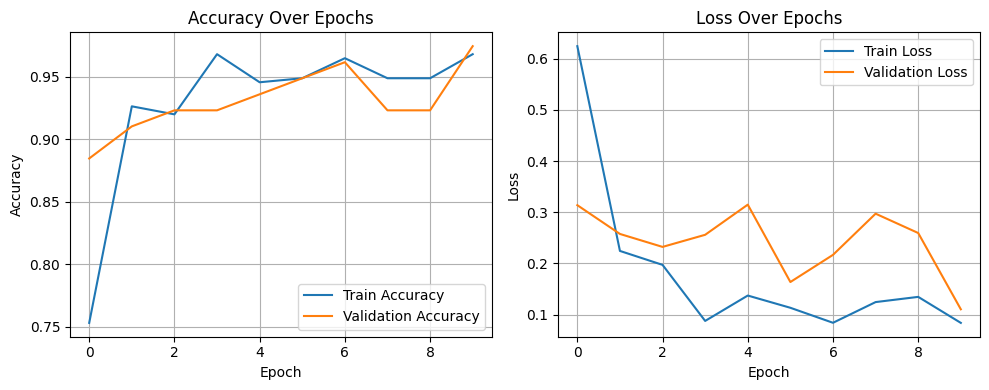

[2025-06-02 15:38:43,849: INFO: 2965070352: ✅ Training history plotted successfully.]


In [39]:
from cnnclassifier import logger  # your custom logger
import matplotlib.pyplot as plt

try:
    logger.info("🔧 Initializing ConfigurationManager...")
    config = ConfigurationManager()
    logger.info("✅ ConfigurationManager initialized.")

    logger.info("🔄 Fetching PrepareCallbacks configuration...")
    prepare_call_backs_config = config.get_prepare_callback_config()
    logger.info("✅ PrepareCallbacksConfig fetched.")

    logger.info("🧰 Initializing PrepCallbacks...")
    prepare_callbacks = PrepCallbacks(config=prepare_call_backs_config)
    logger.info("✅ PrepCallbacks initialized.")

    logger.info("📦 Getting callback list for TensorBoard and Checkpointing...")
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()
    logger.info(f"✅ Callback list ready with {len(callback_list)} callbacks.")

    logger.info("📚 Fetching training configuration...")
    training_config = config.get_training_config()
    logger.info("✅ Training configuration fetched.")

    logger.info("🏗️ Initializing Training class...")
    training = Training(config=training_config)
    logger.info("✅ Training class initialized.")

    logger.info("🚀 Starting model training...")
    history = training.train(callback_list=callback_list)
    logger.info("✅ Model training completed successfully.")

    # 📈 Plot training & validation metrics
    logger.info("📊 Plotting training history...")

    plt.figure(figsize=(10, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    logger.info("✅ Training history plotted successfully.")

except Exception as e:
    logger.exception("❌ An error occurred during the training pipeline execution.")
    raise
